In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from keras.models import Model
import os
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import xgboost as xgb
import h5py

In [2]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 501 #Resize images (height  = X, width = Y)
SIZE_Y = 501


#Capture training image info as a list
train_images = []

dirname = './dataset/data'  
for fname in os.listdir(dirname):
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)   
 
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_stack = np.stack((img,)*3, axis=-1)
    train_images.append(train_stack)
    #train_labels.append(label)
#Convert list to array for machine learning processing        
dataimages = np.array(train_images)


#Capture mask/label info as a list
train_masks = [] 
dirname = './dataset/labels'
for fname in os.listdir(dirname):
    img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    #mask_stack = np.stack((img,)*3, axis=-1)
    train_masks.append(img)
    #print(f"Unique vlaues in labels image {np.unique(img)}")
        #train_labels.append(label)
#Convert list to array for machine learning processing          
labelimages = np.array(train_masks)
X_train, X_test, y_train, y_test = train_test_split(dataimages, labelimages, test_size=0.95, random_state=42)


#Use customary x_train and y_train variables

y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 
y_test = np.expand_dims(y_test, axis=3)

#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
#Talked to the professor and as it seems the input shape makes sure that we can actually run pooling and kernal operations
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 501, 501, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 501, 501, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 501, 501, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

In [ ]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [ ]:
#Test for dimensions

#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
dataset.to_feather('FeatureData.feather')

print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
c:\Users\JohannHaack\source\xray-segmentation\env\lib\site-packages\pyarrow\feather.py:156: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)


[  0 128 255]
Label
128    2767729
0      1895581
255    1611715
Name: count, dtype: int64


In [ ]:
# This is so that we dont overwork our Ram
dataset = dataset.sample(frac=0.005, random_state=1)


#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 128: 1, 255: 2}

# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

# Function to prompt for user decision
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 
#Save model for future use
filename = 'model_XG.sav'
pickle.dump(model, open(filename, 'wb'))
print("Model training complete and saved.")


In [9]:
#This is to print a picture using the models we have
filename = 'model_XG.sav'
loaded_model = pickle.load(open(filename, 'rb'))
print(X_test.shape)

(475, 501, 501, 3)


1/1 [==============================] - 0s 44ms/step
 Class_1_Prob  Class_2_Prob  Class_3_Prob
     0.002303      0.464127      0.533570
     0.594321      0.404131      0.001548
     0.522409      0.474479      0.003112
     0.000039      0.447242      0.552719
     0.371341      0.302884      0.325775
     0.285541      0.193305      0.521155
     0.002036      0.437626      0.560338
     0.000561      0.530762      0.468678
     0.566549      0.432917      0.000534
     0.580492      0.419207      0.000302
     0.007621      0.442177      0.550202
     0.135667      0.368481      0.495852
     0.003353      0.595187      0.401460
     0.000032      0.519988      0.479979
     0.508542      0.488253      0.003205
     0.000088      0.458489      0.541423
     0.561179      0.436526      0.002295
     0.017648      0.572341      0.410011
     0.000033      0.501278      0.498688
     0.000040      0.410789      0.589172
     0.000072      0.581093      0.418835
     0.560825      0.436

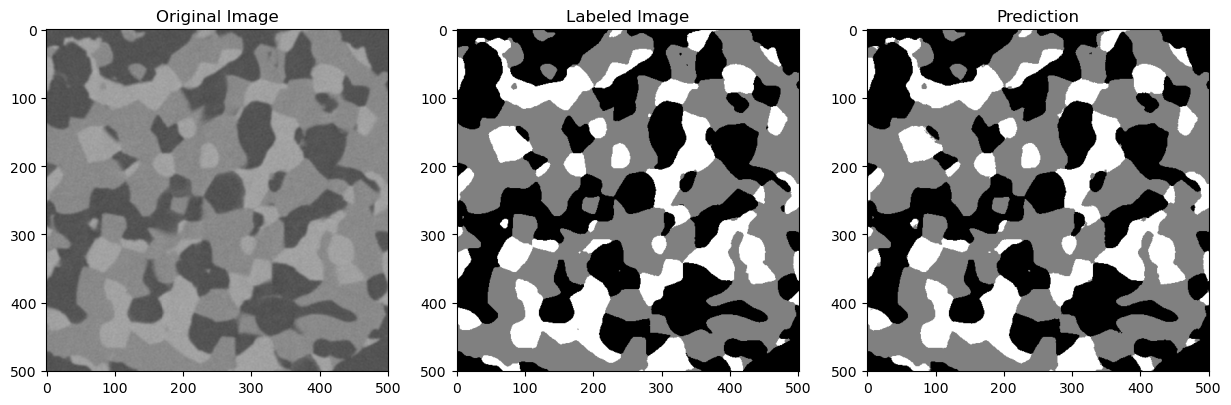

In [9]:
first_image_batch = np.expand_dims(X_test[0], axis=0)  # Reshape to (1, 501, 501, 3)
X_test_feature = new_model.predict(first_image_batch)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
#These are not the exact possibilities that we want as it is the number of trees that hit as XGB is an esemble model. 
pred_probabilities = loaded_model.predict_proba(X_test_feature)
class_probabilities_df = pd.DataFrame(pred_probabilities, 
                                      columns=[f'Class_{i+1}_Prob' for i in range(pred_probabilities.shape[1])])

filtered_df = class_probabilities_df[(class_probabilities_df < 0.6).all(axis=1)]

# Print the DataFrame
print(filtered_df.to_string(index=False))

prediction = loaded_model.predict(X_test_feature)
prediction_image = prediction.reshape((501, 501))
#plt.imshow(prediction_image, cmap='gray')

original_image = np.squeeze(X_test[0])
labeled_images = np.squeeze(y_test[0])  # Removes the singleton dimension if it exists

print(original_image.shape)
print(labeled_images.shape)
# If X_test is a grayscale image with a shape like (n_samples, 501, 501), you might need to do:
# original_image = X_test[0].reshape((501, 501))

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Prediction')

# Show the plot
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import numpy as np
import gc  # Garbage collector interface (to free up memory if needed)

class_values = [0, 128, 255]

def calculate_metrics(y_true, y_pred, num_classes):
    y_pred_mapped = np.copy(y_pred)
    for class_index, class_value in enumerate(class_values):
        y_pred_mapped[y_pred == class_index] = class_value

    y_true_flatten = y_true.flatten()
    y_pred_flatten = y_pred_mapped.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flatten, y_pred_flatten)
    
    # For a multi-class problem, change 'binary' to 'macro' (unweighted average), 'micro' (global average), or 'weighted' (weighted average)
    precision = precision_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    recall = recall_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    f1 = f1_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    iou = jaccard_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    
    return accuracy, precision, recall, f1, iou

# Initialize lists to store metric scores for each image
accuracies = []
precisions = []
recalls = []
f1_scores = []
ious = []

for i in range(len(X_test)):  # Iterate over each image in X_test 
    # Prepare the image for prediction
    image_batch = np.expand_dims(X_test[i], axis=0)
    X_test_feature = new_model.predict(image_batch)
    X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
    prediction = loaded_model.predict(X_test_feature)
    prediction_image = prediction.reshape((501, 501))
    
    # Convert prediction to the same format as ground truth, if necessary
    # Your conversion code here
    
    # Calculate metrics for the current prediction
    accuracy, precision, recall, f1, iou = calculate_metrics(y_test[i], prediction_image, 3)
    
    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    ious.append(iou)
    
    # Clear memory periodically if needed
    if (i+1) % 10 == 0:  # Clear every 10 images, adjust based on your system's memory
        gc.collect()

# Calculate and print the mean of the metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_iou = np.mean(ious)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1 Score: {mean_f1_score}')
print(f'Mean IoU: {mean_iou}')


1/1 [==============================] - 0s 52ms/step
Mean Accuracy: 0.9887341191133858
Mean Precision: 0.9888065913649947
Mean Recall: 0.9884316195853575
Mean F1 Score: 0.9886156990116494
Mean IoU: 0.9775062802339262
